In [1]:
using ITensors
push!(LOAD_PATH,"../src/")
using RandomMeas
using ProgressBars
using MAT
using Revise
# TODO: add MAT to the required dependencies

In [30]:
## parameters 
N = 10
times = [0,1,2,3,4,5] ## quench time between 0 to 5 ms
ntimes = length(times)
ξ = siteinds("Qubit", N);
nu, NM = 500,150
data = zeros(Int8,ntimes,nu,NM,N);
n = 6
NAmax = 7;

In [31]:
#Load theory state
ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NAmax,n-1)
S = zeros(Float64,ntimes,NAmax,n-1)
SvN = zeros(Float64,ntimes,NAmax)
ITensors.disable_warn_order()

for s in 1:ntimes
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(times[s])*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    push!(ρ,ITensor(qstate,vcat(ξ',ξ)))
    for NA in 1:NAmax
        A = collect(1:NA)
        ρA = copy(ρ[s])
        for i in 1:N
            if !(i in A)
                ρA *= δ(ξ[i],ξ[i]')
            end
        end
        for nt in 2:n
            p[s,NA,nt-1] = real(trace(power(ρA,nt),ξ[1:NA]))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
        D, = eigen(ρA,ξ[1:NA]',ξ[1:NA];ishermitian=true)
        for k in 1:2^NA
            if D[k,k]>1e-12
                SvN[s,NA] -= D[k,k]*log2(D[k,k])
            end
        end
    end
end

In [32]:
u = Vector{Vector{Vector{ITensor}}}()
for s in 1:ntimes
    vars = matread("BrydgesScience2019data/unitaries_10_T_" * string(times[s]) * "_flr_1.mat")
    raw_measurements = vars["qstates" * string(times[s])]

    for r in 1:nu
        for m in 1:NM
            data[s,r,m,:] = reverse(digits(floor(Int,raw_measurements[r,m]), base=2, pad=N) .+ 1)
        end
    end    
    
    ut = Vector{Vector{ITensor}}()
    for r in 1:nu
        push!(ut,[ITensor(vars["unitaries"][r,i],ξ[i]',ξ[i]) for i in 1:N])
    end
    push!(u,ut)
end

In [33]:
#Purity from Hamming and shadow formulas
p_hamming = zeros(Float64,ntimes,NAmax)
p_shadow = zeros(Float64,ntimes,NAmax)
for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        p_hamming[s,NA] = get_purity_hamming(data[s,:,:,1:NA],ξ[1:NA])
        p_shadow[s,NA] = get_purity_shadows(data[s,:,:,1:NA],uA,ξ[1:NA])
    end
end

0.0%┣                                                ┫ 0/6 [00:00<00:00, -0s/it]
16.7%┣███████▏                                   ┫ 1/6 [00:02<Inf:Inf, InfGs/it]
33.3%┣████████████████                                ┫ 2/6 [00:04<00:17, 4s/it]
50.0%┣████████████████████████                        ┫ 3/6 [00:06<00:10, 3s/it]
66.7%┣████████████████████████████████                ┫ 4/6 [00:08<00:06, 3s/it]
83.3%┣████████████████████████████████████████        ┫ 5/6 [00:11<00:03, 3s/it]
100.0%┣███████████████████████████████████████████████┫ 6/6 [00:13<00:00, 3s/it]
100.0%┣███████████████████████████████████████████████┫ 6/6 [00:13<00:00, 3s/it]


In [51]:
#Tr(rho^n) and Renyis from batch shadows
p_bshadow = zeros(Float64,ntimes,NAmax,n-1)
S_bshadow = zeros(Float64,ntimes,NAmax,n-1)
for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        ξA = ξ[1:NA]
        @show NA
        @time ρs = get_batch_shadows(data[s,:,:,1:NA],ξA,uA,n)
        @time p_bshadow[s,NA,:] = get_moments(ρs, ξA, n, nu)
        @time for nt in 2:n
            S_bshadow[s,NA,nt-1]= log2(p_bshadow[s,NA,nt-1])/(1-nt)
        end
    end
end

NA = 1
  0.018793 seconds (188.80 k allocations: 27.446 MiB)
  0.018373 seconds (350.24 k allocations: 66.493 MiB)
  0.000029 seconds (29 allocations: 816 bytes)
NA = 2
  0.043791 seconds (403.17 k allocations: 88.425 MiB, 27.79% gc time)


0.0%┣                                                ┫ 0/6 [00:00<00:00, -0s/it]


  0.045004 seconds (500.63 k allocations: 132.006 MiB, 29.82% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 3
  0.063126 seconds (615.79 k allocations: 153.349 MiB, 13.09% gc time)
  0.058734 seconds (594.23 k allocations: 211.557 MiB, 17.47% gc time)
  0.000008 seconds (29 allocations: 816 bytes)
NA = 4
  0.109753 seconds (948.45 k allocations: 257.772 MiB, 6.97% gc time)
  0.107947 seconds (691.73 k allocations: 323.780 MiB, 16.49% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 5
  0.168470 seconds (1.28 M allocations: 423.602 MiB, 13.55% gc time)
  0.187011 seconds (793.13 k allocations: 554.419 MiB, 11.79% gc time)
  0.000008 seconds (29 allocations: 816 bytes)
NA = 6
  0.288496 seconds (1.69 M allocations: 804.137 MiB, 9.80% gc time)
  1.030937 seconds (912.11 k allocations: 1.218 GiB, 4.03% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 7
  0.672913 seconds (2.14 M allocations: 1.957 GiB, 8.33% gc time)
  2.168774 seconds (1.03 M allocat

16.7%┣███████▏                                   ┫ 1/6 [00:05<Inf:Inf, InfGs/it]


  0.033608 seconds (500.63 k allocations: 132.006 MiB)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 3
  0.060172 seconds (618.31 k allocations: 153.431 MiB, 16.59% gc time)
  0.081765 seconds (594.23 k allocations: 211.557 MiB, 32.72% gc time)
  0.000008 seconds (29 allocations: 816 bytes)
NA = 4
  0.090033 seconds (978.07 k allocations: 258.827 MiB, 8.85% gc time)
  0.093593 seconds (691.73 k allocations: 323.780 MiB, 18.56% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 5
  0.159171 seconds (1.36 M allocations: 425.870 MiB, 13.03% gc time)
  0.183773 seconds (793.13 k allocations: 554.419 MiB, 12.99% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 6
  0.291256 seconds (1.86 M allocations: 812.018 MiB, 10.12% gc time)
  0.596778 seconds (912.11 k allocations: 1.218 GiB, 6.49% gc time)
  0.000017 seconds (29 allocations: 816 bytes)
NA = 7
  0.677435 seconds (2.43 M allocations: 1.968 GiB, 10.06% gc time)
  1.472566 seconds (1.03 M allocations: 3.688 Gi

33.3%┣████████████████                                ┫ 2/6 [00:09<00:35, 9s/it]


  0.032546 seconds (500.63 k allocations: 132.006 MiB)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 3
  0.064389 seconds (618.53 k allocations: 153.438 MiB, 16.91% gc time)
  0.074174 seconds (594.23 k allocations: 211.557 MiB, 26.35% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 4
  0.088304 seconds (984.26 k allocations: 258.990 MiB, 9.29% gc time)
  0.094274 seconds (691.73 k allocations: 323.780 MiB, 18.87% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 5
  0.166657 seconds (1.39 M allocations: 426.651 MiB, 12.59% gc time)
  0.187040 seconds (793.13 k allocations: 554.419 MiB, 12.13% gc time)
  0.000008 seconds (29 allocations: 816 bytes)
NA = 6
  0.298207 seconds (1.93 M allocations: 816.462 MiB, 9.60% gc time)
  0.480640 seconds (912.11 k allocations: 1.218 GiB, 10.49% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 7
  0.714202 seconds (2.55 M allocations: 1.972 GiB, 8.13% gc time)
  1.965419 seconds (1.03 M allocations: 3.688 GiB

50.0%┣████████████████████████                        ┫ 3/6 [00:13<00:20, 7s/it]


  0.043878 seconds (500.63 k allocations: 132.006 MiB, 23.86% gc time)
  0.000026 seconds (29 allocations: 816 bytes)
NA = 3
  0.056608 seconds (618.58 k allocations: 153.439 MiB, 14.58% gc time)
  0.060180 seconds (594.23 k allocations: 211.557 MiB, 18.34% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 4
  0.094202 seconds (986.86 k allocations: 259.059 MiB, 9.10% gc time)
  0.094093 seconds (691.73 k allocations: 323.780 MiB, 18.78% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 5
  0.166026 seconds (1.40 M allocations: 427.072 MiB, 13.72% gc time)
  0.183592 seconds (793.13 k allocations: 554.419 MiB, 12.40% gc time)
  0.000010 seconds (29 allocations: 816 bytes)
NA = 6
  0.295121 seconds (1.98 M allocations: 818.238 MiB, 10.14% gc time)
  0.457605 seconds (912.11 k allocations: 1.218 GiB, 10.66% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 7
  0.660945 seconds (2.64 M allocations: 1.974 GiB, 8.62% gc time)
  1.771015 seconds (1.03 M alloc

66.7%┣████████████████████████████████                ┫ 4/6 [00:17<00:11, 6s/it]


  0.032464 seconds (500.63 k allocations: 132.006 MiB)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 3
  0.058223 seconds (618.58 k allocations: 153.439 MiB, 18.70% gc time)
  0.060015 seconds (594.23 k allocations: 211.557 MiB, 16.31% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 4
  0.101387 seconds (988.03 k allocations: 259.089 MiB, 19.45% gc time)
  0.094471 seconds (691.73 k allocations: 323.780 MiB, 19.70% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 5
  0.159473 seconds (1.41 M allocations: 427.282 MiB, 9.33% gc time)
  0.203875 seconds (793.13 k allocations: 554.419 MiB, 16.22% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 6
  0.285357 seconds (2.00 M allocations: 818.846 MiB, 8.10% gc time)
  0.371566 seconds (912.11 k allocations: 1.218 GiB, 11.71% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 7
  0.684941 seconds (2.67 M allocations: 1.975 GiB, 8.68% gc time)
  1.803270 seconds (1.03 M allocations: 3.688 GiB

83.3%┣████████████████████████████████████████        ┫ 5/6 [00:21<00:05, 5s/it]


  0.033889 seconds (500.63 k allocations: 132.006 MiB)
  0.000008 seconds (29 allocations: 816 bytes)
NA = 3
  0.061945 seconds (618.59 k allocations: 153.440 MiB, 18.32% gc time)
  0.064413 seconds (594.23 k allocations: 211.557 MiB, 15.32% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 4
  0.104167 seconds (988.42 k allocations: 259.100 MiB, 19.08% gc time)
  0.096246 seconds (691.73 k allocations: 323.780 MiB, 20.04% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 5
  0.162901 seconds (1.42 M allocations: 427.457 MiB, 10.08% gc time)
  0.187415 seconds (793.13 k allocations: 554.419 MiB, 12.59% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 6
  0.309016 seconds (2.02 M allocations: 819.483 MiB, 10.77% gc time)
  0.571556 seconds (912.11 k allocations: 1.218 GiB, 8.20% gc time)
  0.000009 seconds (29 allocations: 816 bytes)
NA = 7
  0.681004 seconds (2.71 M allocations: 1.977 GiB, 7.77% gc time)
  1.656708 seconds (1.03 M allocations: 3.688 Gi

100.0%┣███████████████████████████████████████████████┫ 6/6 [00:25<00:00, 5s/it]
100.0%┣███████████████████████████████████████████████┫ 6/6 [00:25<00:00, 5s/it]


In [35]:
#Tr(rho^n) and Renyis from batch shadows
p_bshadow_jk = zeros(Float64,nu,ntimes,NAmax,n-1)
S_bshadow_jk = zeros(Float64,nu,ntimes,NAmax,n-1)

function find_group(vector_of_vectors, i)
    for (index, vec) in pairs(vector_of_vectors)
        if i in vec
            return index, length(vec)
        end
    end
    return nothing, 0  # Return nothing and size 0 if the integer is not found
end

function get_batches(data::Array{Int8}, n::Int64)
    batches = Vector{Vector{Int}}()
    nu = size(data, 1)
    nu_n = nu ÷ n
    for t in 1:n
        push!(batches,collect(1+(t-1)*nu_n:t*nu_n))
    end
    return batches
end

for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
            @show s,NA
            uA = [ut[1:NA] for ut in u[s]]
            ξA = ξ[1:NA]
            ρs = get_batch_shadows(data[s,:,:,1:NA],ξA,uA,n)
            batches = get_batches(data[s,:,:,1:NA],n) # A vector of vectors, specifying which shadow in which batch 
            for r in 1:batches[end][end]
                ρr = get_batch_shadows(reshape(data[s,r,:,1:NA],1,NM,NA),ξA,[uA[r]],1) # get the shadow of r
                batch,batch_size = find_group(batches,r) # find the batch of shadow r
                ρs_r = copy(ρs) 
                ρs_r[batch] = ((ρs_r[batch]*batch_size)-ρr[1])/(batch_size-1) # substract shadow r from the correct batch shadow
                p_bshadow_jk[r,s,NA,:] = get_moments(ρs_r, ξA, n, nu) # do the estimation of shadow r removed
                for nt in 2:n
                    S_bshadow_jk[r,s,NA,nt-1]= log2(p_bshadow_jk[r,s,NA,nt-1])/(1-nt)
                end
            end
    end
end

(s, NA) = (1, 1)
 11.639272 seconds (174.66 M allocations: 32.369 GiB, 18.89% gc time, 0.06% compilation time)


0.0%┣                                                ┫ 0/6 [00:00<00:00, -0s/it]


(s, NA) = (1, 2)
 20.130727 seconds (249.77 M allocations: 64.293 GiB, 21.15% gc time)
(s, NA) = (1, 3)
 30.549718 seconds (296.60 M allocations: 103.050 GiB, 21.68% gc time)
(s, NA) = (1, 4)
 53.053250 seconds (345.49 M allocations: 157.739 GiB, 21.79% gc time)
(s, NA) = (1, 5)
 93.811666 seconds (396.34 M allocations: 270.091 GiB, 13.08% gc time)
(s, NA) = (1, 6)
195.283161 seconds (456.04 M allocations: 607.556 GiB, 11.14% gc time)
(s, NA) = (1, 7)
665.215646 seconds (513.80 M allocations: 1.796 TiB, 6.37% gc time)
(s, NA) = (2, 1)
 11.749773 seconds (174.66 M allocations: 32.368 GiB, 17.88% gc time)


16.7%┣███████▏                                   ┫ 1/6 [17:51<Inf:Inf, InfGs/it]


(s, NA) = (2, 2)
 20.401169 seconds (249.77 M allocations: 64.293 GiB, 20.26% gc time)
(s, NA) = (2, 3)
 35.587254 seconds (296.61 M allocations: 103.050 GiB, 28.63% gc time)
(s, NA) = (2, 4)
 51.600672 seconds (345.52 M allocations: 157.740 GiB, 21.74% gc time)
(s, NA) = (2, 5)
469.179918 seconds (396.42 M allocations: 270.094 GiB, 3.03% gc time)
(s, NA) = (2, 6)
202.624842 seconds (456.21 M allocations: 607.564 GiB, 11.03% gc time)
(s, NA) = (2, 7)
2309.103639 seconds (514.09 M allocations: 1.796 TiB, 2.11% gc time)
(s, NA) = (3, 1)
 12.455017 seconds (174.66 M allocations: 32.368 GiB, 19.01% gc time)


33.3%┣█████████████                          ┫ 2/6 [01:09:33<04:38:12, 4.2ks/it]


(s, NA) = (3, 2)
 20.884154 seconds (249.77 M allocations: 64.293 GiB, 20.74% gc time)
(s, NA) = (3, 3)
 32.461083 seconds (296.61 M allocations: 103.050 GiB, 21.59% gc time)
(s, NA) = (3, 4)
 51.346022 seconds (345.53 M allocations: 157.741 GiB, 18.39% gc time)
(s, NA) = (3, 5)
105.080202 seconds (396.45 M allocations: 270.094 GiB, 15.86% gc time)
(s, NA) = (3, 6)
188.701584 seconds (456.28 M allocations: 607.568 GiB, 11.72% gc time)
(s, NA) = (3, 7)
4844.903739 seconds (514.21 M allocations: 1.796 TiB, 34.73% gc time)
(s, NA) = (4, 1)
 11.821358 seconds (174.66 M allocations: 32.368 GiB, 18.03% gc time)


50.0%┣███████████████████▌                   ┫ 3/6 [02:37:10<03:55:46, 4.7ks/it]


(s, NA) = (4, 2)
 23.113346 seconds (249.77 M allocations: 64.293 GiB, 30.07% gc time)
(s, NA) = (4, 3)
 31.409460 seconds (296.61 M allocations: 103.050 GiB, 21.43% gc time)
(s, NA) = (4, 4)
 48.280811 seconds (345.53 M allocations: 157.741 GiB, 18.03% gc time)
(s, NA) = (4, 5)
 94.385385 seconds (396.46 M allocations: 270.095 GiB, 12.70% gc time)
(s, NA) = (4, 6)
193.947733 seconds (456.33 M allocations: 607.570 GiB, 11.90% gc time)
(s, NA) = (4, 7)
606.324468 seconds (514.30 M allocations: 1.796 TiB, 7.46% gc time)
(s, NA) = (5, 1)
 11.971713 seconds (174.66 M allocations: 32.368 GiB, 18.02% gc time)


66.7%┣██████████████████████████             ┫ 4/6 [02:54:01<01:56:01, 3.5ks/it]


(s, NA) = (5, 2)
 20.651364 seconds (249.77 M allocations: 64.293 GiB, 20.34% gc time)
(s, NA) = (5, 3)
 35.183710 seconds (296.61 M allocations: 103.050 GiB, 27.54% gc time)
(s, NA) = (5, 4)
 48.757988 seconds (345.53 M allocations: 157.741 GiB, 18.55% gc time)
(s, NA) = (5, 5)
101.925078 seconds (396.47 M allocations: 270.095 GiB, 13.80% gc time)
(s, NA) = (5, 6)
200.513724 seconds (456.35 M allocations: 607.571 GiB, 12.42% gc time)
(s, NA) = (5, 7)
604.430954 seconds (514.33 M allocations: 1.796 TiB, 7.23% gc time)
(s, NA) = (6, 1)
 14.922445 seconds (174.66 M allocations: 32.368 GiB, 29.03% gc time)


83.3%┣███████████████████████████████████       ┫ 5/6 [03:11:06<47:47, 2.9ks/it]


(s, NA) = (6, 2)
 21.606363 seconds (249.77 M allocations: 64.293 GiB, 20.18% gc time)
(s, NA) = (6, 3)
 31.925681 seconds (296.61 M allocations: 103.050 GiB, 21.68% gc time)
(s, NA) = (6, 4)
 48.584463 seconds (345.53 M allocations: 157.741 GiB, 18.24% gc time)
(s, NA) = (6, 5)
100.892380 seconds (396.48 M allocations: 270.095 GiB, 13.92% gc time)
(s, NA) = (6, 6)
192.603543 seconds (456.37 M allocations: 607.571 GiB, 13.35% gc time)
(s, NA) = (6, 7)
609.535703 seconds (514.37 M allocations: 1.796 TiB, 7.72% gc time)


100.0%┣█████████████████████████████████████████┫ 6/6 [03:28:08<00:00, 2.5ks/it]
100.0%┣█████████████████████████████████████████┫ 6/6 [03:28:08<00:00, 2.5ks/it]


In [38]:
using NPZ

#npzwrite("jk_brydges.npz",Dict("p_bshadow_jk"=>p_bshadow_jk,"S_bshadow_jk"=>S_bshadow_jk))



In [47]:
vars = npzread("jk_brydges.npz")
S_bshadow_jk = vars["S_bshadow_jk"]
p_bshadow_jk = vars["p_bshadow_jk"]

500×6×7×5 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0427115  0.430898  0.960127  0.990617  0.997393  0.948916
 0.0487758  0.434242  0.960341  0.990727  0.997482  0.950045
 0.0401273  0.42969   0.960116  0.990507  0.997382  0.948985
 0.0423817  0.430923  0.96025   0.990649  0.997356  0.949116
 0.0403728  0.429849  0.960011  0.990649  0.997333  0.94891
 0.0446676  0.433693  0.960131  0.990681  0.997344  0.949449
 0.0438322  0.431366  0.960295  0.990854  0.997363  0.948885
 0.0406635  0.430057  0.960101  0.990676  0.997351  0.948858
 0.0407973  0.430016  0.960036  0.990634  0.997325  0.948872
 0.0460398  0.432827  0.960425  0.990846  0.99733   0.949501
 ⋮                                                  ⋮
 0.0460154  0.433375  0.960498  0.990738  0.997391  0.94909
 0.0401439  0.429733  0.96008   0.990628  0.997327  0.948797
 0.0469726  0.433126  0.960223  0.990847  0.997385  0.949726
 0.0471211  0.433884  0.960241  0.990731  0.997265  0.949242
 0.0396946  0.429252  0.960073  0.99066   0.997348

In [77]:
using Statistics
size(p_bshadow_jk)
p_bshadow_jk_mean = mean(p_bshadow_jk[1:498,:,:,:],dims=1)
p_bshadow_jk_mean = p_bshadow_jk_mean[1,:,:,:]
S_bshadow_jk_mean = mean(S_bshadow_jk[1:498,:,:,:],dims=1)
S_bshadow_jk_mean = S_bshadow_jk_mean[1,:,:,:]

@show size(p_bshadow_jk_mean) size(p_bshadow)
p_bshadow_jk_bias = 497 * (p_bshadow_jk_mean - p_bshadow)
S_bshadow_jk_bias = 497 * (S_bshadow_jk_mean - S_bshadow)

@show maximum(abs.(p_bshadow_jk_bias)) 
@show maximum(abs.(S_bshadow_jk_bias)) 

p_bshadow_jk_var =497*var(p_bshadow_jk[1:498,:,:,:],dims=1,corrected=false)
p_bshadow_jk_var=p_bshadow_jk_var[1,:,:,:]
S_bshadow_jk_var =497*var(S_bshadow_jk[1:498,:,:,:],dims=1,corrected=false)
S_bshadow_jk_var=S_bshadow_jk_var[1,:,:,:]
@show maximum((p_bshadow_jk_var)) 
@show maximum((S_bshadow_jk_var)) 


size(p_bshadow_jk_mean) = (6, 7, 5)
size(p_bshadow) = (6, 7, 5)
maximum(abs.(p_bshadow_jk_bias)) = 8.276712648580542e-13
maximum(abs.(S_bshadow_jk_bias)) = 0.03368996987781264
maximum(p_bshadow_jk_var) = 0.0351495625405987
maximum(S_bshadow_jk_var) = 0.09124245879877001


0.09124245879877001

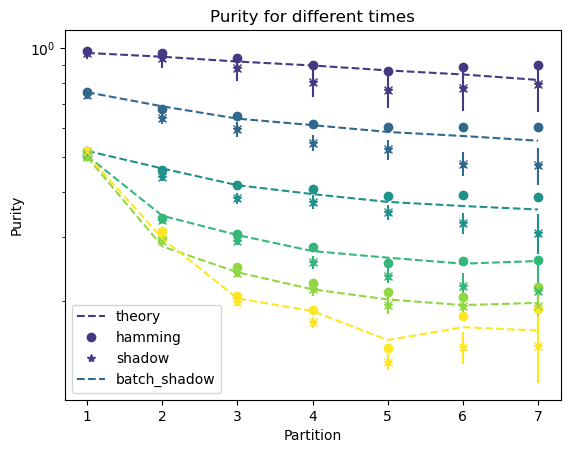

In [76]:
using PyPlot

clf()

cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NAmax,p[s,:,1],"--",color=cm(s/ntimes))
    plot(1:NAmax,p_hamming[s,:],"o",color=cm(s/ntimes))
    #plot(1:NAmax,p_shadow[s,:],"x",color=cm(s/ntimes))
    #plot(1:NAmax,p_bshadow[s,:,1],"*",color=cm(s/ntimes))
    errorbar(1:NAmax,p_bshadow[s,:,1]-p_bshadow_jk_bias[s,:,1],yerr=sqrt.(p_bshadow_jk_var[s,:,1]),fmt="x",color=cm(s/ntimes))

end
yscale("log")
xlabel("Partition")
ylabel("Purity")
legend(["theory","hamming","shadow","batch_shadow"])
title("Purity for different times")

gcf()

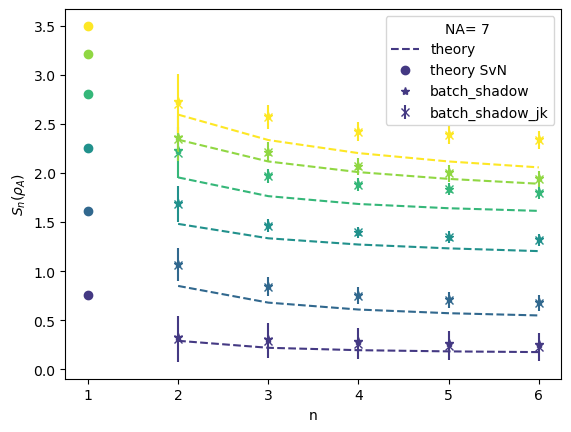

In [101]:
using PyPlot

clf()

co = ["blue","red","green","magenta","orange","black"]
NA = 7

for s in 1:1
    plot(2:n,S[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot([1],[SvN[s,NA]],"o",color=cm(s/ntimes),label="theory SvN")
    plot(2:n,S_bshadow[s,NA,:],"*",color=cm(s/ntimes),label="batch_shadow")
    errorbar(2:n,S_bshadow[s,NA,:]-S_bshadow_jk_bias[s,NA,:],yerr=sqrt.(S_bshadow_jk_var[s,NA,:]),fmt="x",color=cm(s/ntimes),label="batch_shadow_jk")
end
for s in 2:ntimes
    plot(2:n,S[s,NA,:],"--",color=cm(s/ntimes))
    plot([1],[SvN[s,NA]],"o",color=cm(s/ntimes))
    plot(2:n,S_bshadow[s,NA,:],"*",color=cm(s/ntimes))
    errorbar(2:n,S_bshadow[s,NA,:]-S_bshadow_jk_bias[s,NA,:],yerr=sqrt.(S_bshadow_jk_var[s,NA,:]),fmt="x",color=cm(s/ntimes))
end
#yscale("log")
xlabel("n")
ylabel(L"S_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()

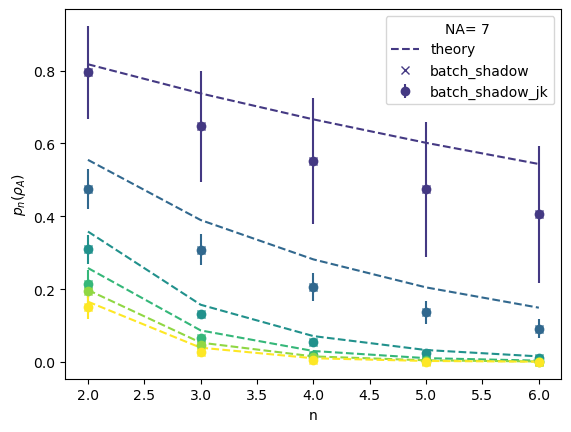

In [99]:
using PyPlot

clf()

co = ["blue","red","green","magenta","orange","black"]
NA = 7
for s in 1:1
    plot(2:n,p[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot(2:n,p_bshadow[s,NA,:],"x",color=cm(s/ntimes),label="batch_shadow")
    errorbar(2:n,p_bshadow[s,NA,:]-p_bshadow_jk_bias[s,NA,:],yerr=sqrt.(p_bshadow_jk_var[s,NA,:]),fmt="o",color=cm(s/ntimes),label="batch_shadow_jk")
end
for s in 2:ntimes
    plot(2:n,p[s,NA,:],"--",color=cm(s/ntimes))
    plot(2:n,p_bshadow[s,NA,:],"x",color=cm(s/ntimes))
    errorbar(2:n,p_bshadow[s,NA,:]-p_bshadow_jk_bias[s,NA,:],yerr=sqrt.(p_bshadow_jk_var[s,NA,:]),fmt="o",color=cm(s/ntimes))
end
#yscale("log")
xlabel("n")
ylabel(L"p_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()
